# Linux kernel - Netdev (Networking) Subsystem

Linux Netdev is a mailing list for all network-related Linux stuff.  This includes anything found under net/  (i.e. core code like IPv6) and drivers/net (i.e. hardware specific drivers) in the Linux source tree.

Code review at Linux Netdev is performed in mailing lists. Sucessful reviewed patches are commited the mainline tree managed Linus.  This approach migrates that code review into a database schema closer to how Gerrit or another review system works.

# Methodology

1. Retrieval of mailing list information
*  Retreivial of Git information
*  Detection and classification of code review messsages
*  Produce code review database(list db): Auto merge (mailing list +      git messages)
*  Analysis: Querying databases, measure metrics: Ipython notebook,        pandas and interprete results

The analysis is conducted from 2011-01 to 2015-12

The list of metrics for this notebook are the following ones:

Activity General Overview
-------------------------
* Evolution of patch series (1 or more patches)
* Evolution of patch series submitters
* Evolution of comments
* Evolution of people commenting the patch series
* Evolution of people reviewing patches (using the flag reviewed by)

Time analysis
-------------

A patch can be divided into several steps:

1---------2----------3---------4--------5---------A--------C

And each version can be divided into several steps:

1----a)review------b)review------c)review-----------d)review--------------2----------------------------------------------3
    
    

Where 1, 2, 3, .., are the several iterations, A the point where all of the patches were 'Acked-by' and C the commit action into master.
And a, b, c, d comments and reviews.


* Time to merge: time between 1 and C
* Time to commit: time between A and C
* Time to re-work a patch: time between 1_d and the new iteration. Time between the last comment and a new patch.
* Cycle time: time between each pair of iterations: 1&2, 2&3, etc.
* Time to first review: time between 1, 2, 3, etc and its first review.

Backlog analysis
----------------
* Review (of series/patch) completed: all of the patch series merged
* Review (of series/patch) active: patches that were recently reviewed, we'll take the last 7 days as a potential timeframe.
* Review (of series/patch) stalled: patches older than 1 year
* Review (of series/patch) ongoing: patches younger than 1 year. This would include the active reviews.

Patch series complexity analysis
--------------------------------
* Number of versions per patch serie
* From patches merged: check number of 'touched' files plus added and removed lines
* Comments received per patch
* Number of patches per patch serie

Patch series community
----------------------
* Top people sending patches
* Top people reviewing patches
* For all of those, basic analysis with organization info based on email domain

Analysis
--------


# 0) LIBRARIES NEEDED FOR THIS NOTEBOOK

In [2]:
%pylab inline
# Enabling libraries to manage data and plot
import pandas as pd
import numpy as np
from pandas import Series, DataFrame, Panel

Populating the interactive namespace from numpy and matplotlib


# 0) DATABASE CONNECTION

In [135]:
# Working with the xen-database with code review info
import MySQLdb


def connect():
   user = "root"
   password = ""
   host = "localhost"
   db = "linux_netdev_codeReview"

   try:
      db = MySQLdb.connect(user = user, passwd = password, db = db)
      return db, db.cursor()
   except:
      logging.error("Database connection error")
      raise
        


def execute_query(connector, query):
   results = int (connector.execute(query))
   cont = 0
   if results > 0:
      result1 = connector.fetchall()
      return result1
   else:
      return []
    

db, cursor = connect()

In [136]:
def draw_distribution(data_df, key_field, hist, boxplot, boxplot_log=True):
    # This function draws as histogram and boxplot the distribution 
    # of the specified charts.
    # data: raw data coming from database
    # columns_list: list of columns represented in 'data'
    # key_field: key field to be represented in the histogram and boxplot
    # hist: contains the xlabel, ylabel and title fields
    # boxplot: contains the ylabel and title fields
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))

    hist_chart = data_df[key_field].plot(kind="hist", ax=axs[0])
    boxplot_chart = data_df[key_field].plot(kind="box", ax=axs[1], logy=boxplot_log)

    #chart labels
    hist_chart.set_xlabel(hist["xlabel"])
    hist_chart.set_ylabel(hist["ylabel"])
    hist_chart.set_title(hist["title"])

    boxplot_chart.set_ylabel(boxplot["ylabel"])
    boxplot_chart.set_title(boxplot["title"])

# 1) ACTIVITY GENERAL OVERVIEW

Metrics to retrieve:
* Evolution of patch series (1 or more patches)
* Evolution of patch series submitters
* Evolution of comments
* Evolution of people commenting the patch series
* Evolution of people reviewing patches (using the flag reviewed by)

## Evolution of Patch Series

Xen community uses the term patch or patch serie when sending pieces of code to the mailing list. In order to simplify this process, a patch serie is now conformed of one or more patches.

In [137]:
query = """ SELECT year,month,count(distinct(ps)) as patch_series
            FROM 
                 (SELECT ps_version_id as ps,
                         year(min(date)) as year,
                         month(min(date)) as month
                  FROM list.patches
                  GROUP BY ps_version_id
                  ORDER BY min(date)) t
            GROUP BY year, month
        """
data = execute_query(cursor, query)

In [138]:
np_data = np.array(data)
np_data_filtered = np_data[12:-3] # This removes the 2016 data
#Migrating to use Series in pandas (nicer view and easier to manage series)
dates = pd.date_range('2012-01', '2016-01', freq='M') # data starting in 2004-08 and ending in 2015-08
#Checking size of both arrays: dates.shape and np_data_filtered.shape
#len(np_data_filtered[:,2])
#len(np_data),len(np_data_filtered), len(np_data_filtered[:,2]), len(dates)
patchserieTS = Series(np_data_filtered[:,2], index=dates)

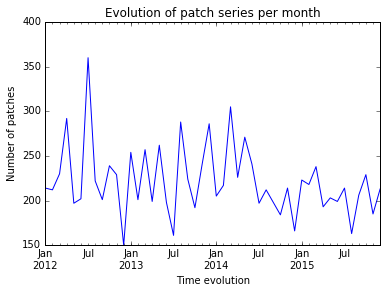

In [139]:
patchserieschart = patchserieTS.plot()
patchserieschart.set_xlabel("Time evolution")
patchserieschart.set_ylabel("Number of patches")
patchserieschart.set_title("Evolution of patch series per month")

## Evolution of Patch Series Submitters

In [8]:
query = """ SELECT year,month,count(distinct(ps)) as patch_series
            FROM 
                 (SELECT ps_version_id as ps,
                         year(min(date)) as year,
                         month(min(date)) as month
                  FROM list.patches
                  GROUP BY ps_version_id
                  ORDER BY min(date)) t
            GROUP BY year, month
        """
data_submitters = execute_query(cursor, query)

In [9]:
np_data = np.array(data_submitters)
np_data_filtered = np_data[12:-3] # This removes 2016 data
patchserie_submittersTS = Series(np_data_filtered[:,2], index=dates)

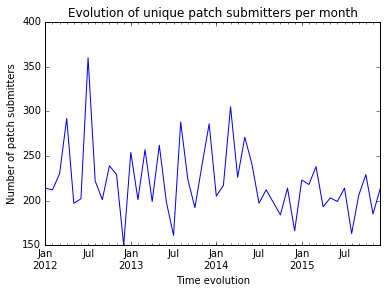

In [10]:
patchserie_submitters_chart = patchserie_submittersTS.plot()
patchserie_submitters_chart.set_xlabel("Time evolution")
patchserie_submitters_chart.set_ylabel("Number of patch submitters")
patchserie_submitters_chart.set_title("Evolution of unique patch submitters per month")

## Evolution of comments

In [11]:
# Let's calculate evolution of comments in general when they were sent
# We should ignore 1970 emails with wrong sent date
query = """ SELECT year(date) as year,
                   month(date) as month,
                   count(distinct(comments.id)) as comments
            FROM list.comments
            WHERE year(date) > 2010
            GROUP BY year(date),
                     month(date)
        """
comments = execute_query(cursor, query)

In [12]:
np_data = np.array(comments)
np_data_filtered = np_data[12:-3]
dates = pd.date_range('2012-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
commentsTS = Series(np_data_filtered[:,2], index=dates)

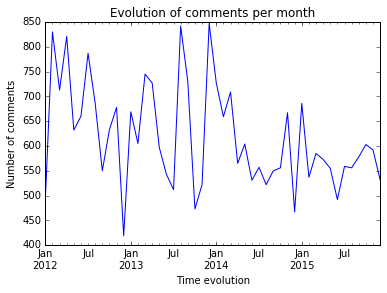

In [13]:
comments_chart = commentsTS.plot()
comments_chart.set_xlabel("Time evolution")
comments_chart.set_ylabel("Number of comments")
comments_chart.set_title("Evolution of comments per month")

## Evolution of people commenting the patch series

In [14]:
query = """ SELECT psv.ps_id as patch_serie,
                   MIN(psv.date) as patch_serie_sent_date,
                   COUNT(DISTINCT(c.submitter_id)) as commenters
            FROM list.patch_series_version psv,
                 list.patches p,
                 list.comments c 
            WHERE psv.id = p.ps_version_id AND 
                  p.id=c.patch_id 
            GROUP BY psv.ps_id """
peoplecomments_ps = execute_query(cursor, query)

In [15]:
peoplecomments_list = list(peoplecomments_ps)
#peoplecomments_ps
peoplecomments_df = DataFrame(peoplecomments_list, columns=["patch_serie", "partch_serie_sent_date", "commenters"])

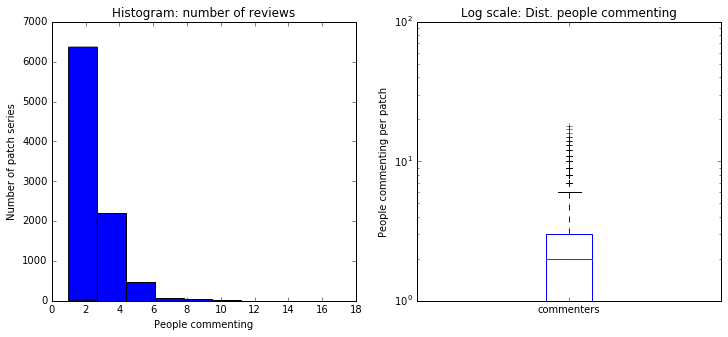

In [16]:
hist = {"xlabel":"People commenting", "ylabel":"Number of patch series", "title":"Histogram: number of reviews"}
boxplot = {"ylabel":"People commenting per patch", "title":"Log scale: Dist. people commenting"}
draw_distribution(peoplecomments_df, "commenters", hist, boxplot)

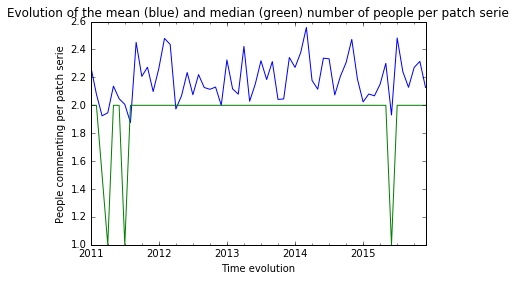

In [17]:
mean_peoplecomments = peoplecomments_df.set_index("partch_serie_sent_date").resample('M', how={"commenters":np.mean})
median_peoplecomments = peoplecomments_df.set_index("partch_serie_sent_date").resample('M', how={"commenters":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-12
peoplecommentsTS = Series(mean_peoplecomments["commenters"], index=dates)
peoplecomments_medianTS = Series(median_peoplecomments["commenters"], index=dates)

peoplecommentsTS_chart = peoplecommentsTS.plot()
peoplecomments_medianTS.plot()
peoplecommentsTS_chart.set_xlabel("Time evolution")
peoplecommentsTS_chart.set_ylabel("People commenting per patch serie")
peoplecommentsTS_chart.set_title("Evolution of the mean (blue) and median (green) number of people per patch serie")

In [18]:
#dates

# 2) TIME ANALYSIS

Metrics to retrieve:
* Time to merge: time between 1 and C
* Time to commit: time between A and C
* Time to re-work a patch: time between 1_d and the new iteration. Time between the last comment and a new patch.
* Cycle time: time between each pair of iterations: 1&2, 2&3, etc.
* Time to first review: time between 1, 2, 3, etc and its first review.
* Time to ack

## Time to merge

Time to merge needs to be calculated as the time when a patch was initially sent till this is merge into code. As each patch is associated to a commit, this is obtained as the first date when the patch was sent till the last commit for that patch serie is merged into code.

In [19]:
query = """ SELECT psv.ps_id as patch_serie,
                   TIMESTAMPDIFF(SECOND, MIN(psv.date), MAX(c.committer_date)) as time2merge,
                   MIN(psv.date) as first_patch_date,
                   MAX(c.committer_date) as merge_time
            FROM list.patch_series_version psv,
                 list.patches p,
                 list.commits c
            WHERE psv.id=p.ps_version_id AND 
                  p.commit_id = c.id 
            GROUP BY psv.ps_id
            HAVING time2merge >=0; """
time2merge = execute_query(cursor, query)

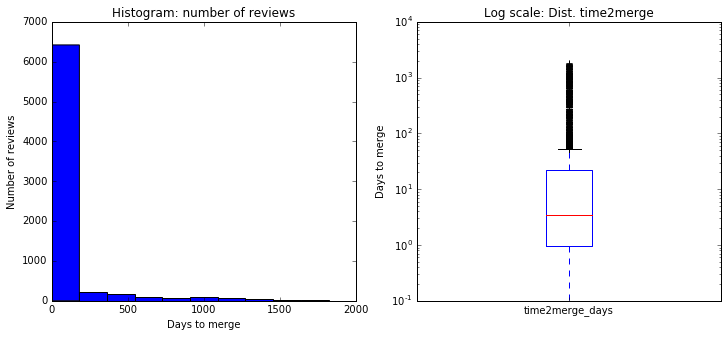

In [20]:
time2merge_list = list(time2merge)
time2merge_df = DataFrame(time2merge_list, columns=["patch_serie", "time2merge", "first_patch_date", "merge_time"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2merge_df["time2merge_days"] = (time2merge_df["time2merge"]/3600)/24


hist_chart = time2merge_df["time2merge_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2merge_df["time2merge_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to merge")
hist_chart.set_ylabel("Number of reviews")
hist_chart.set_title("Histogram: number of reviews")

boxplot_chart.set_ylabel("Days to merge")
boxplot_chart.set_title("Log scale: Dist. time2merge")

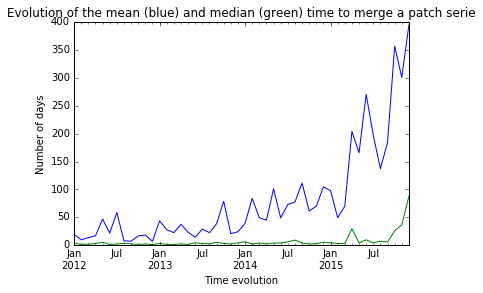

In [21]:
mean_time2merge = time2merge_df.set_index("merge_time").resample('M', how={"time2merge_days":np.mean})
median_time2merge = time2merge_df.set_index("merge_time").resample('M', how={"time2merge_days":np.median})
dates = pd.date_range('2012-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
time2mergeTS = Series(mean_time2merge["time2merge_days"], index=dates)
time2merge_medianTS = Series(median_time2merge["time2merge_days"], index=dates)

time2mergeTS_chart = time2mergeTS.plot()
time2merge_medianTS.plot()
time2mergeTS_chart.set_xlabel("Time evolution")
time2mergeTS_chart.set_ylabel("Number of days")
time2mergeTS_chart.set_title("Evolution of the mean (blue) and median (green) time to merge a patch serie")

## Time to commit

In [22]:
query = """ SELECT psv.ps_id as patch_serie,
                   TIMESTAMPDIFF(SECOND, MAX(c.date), MAX(commits.committer_date)) as time2commit,
                   MAX(c.date) as last_comment_date, 
                   MAX(commits.committer_date) as commit_time 
            FROM list.patch_series_version psv,
                 list.patches p,
                 list.comments c, 
				 list.commits 
            WHERE psv.id = p.ps_version_id AND 
                  p.commit_id = commits.id AND 
                  p.id=c.patch_id 
            GROUP BY psv.ps_id
            HAVING time2commit >= 0 and time2commit < 2000*3600*24"""
time2commit = execute_query(cursor, query)

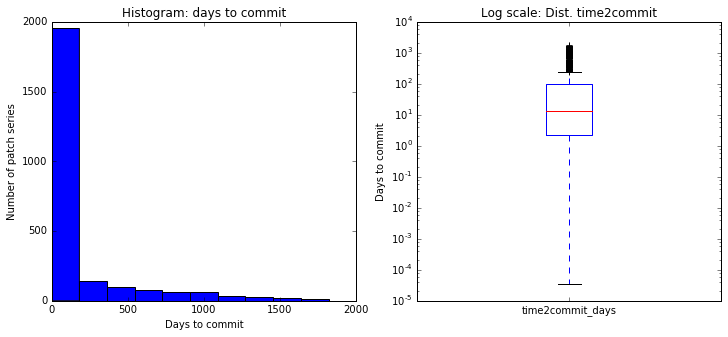

In [23]:
time2commit_list = list(time2commit)
time2commit_df = DataFrame(time2commit_list, columns=["patch_serie", "time2commit", "last_comment_date", "commit_time"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2commit_df["time2commit_days"] = (time2commit_df["time2commit"]/3600)/24


hist_chart = time2commit_df["time2commit_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2commit_df["time2commit_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to commit")
hist_chart.set_ylabel("Number of patch series")
hist_chart.set_title("Histogram: days to commit")

boxplot_chart.set_ylabel("Days to commit")
boxplot_chart.set_title("Log scale: Dist. time2commit")

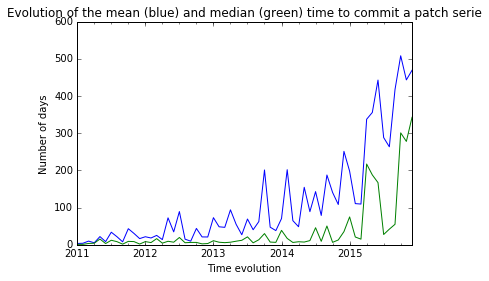

In [24]:
mean_time2commit = time2commit_df.set_index("commit_time").resample('M', how={"time2commit_days":np.mean})
median_time2commit = time2commit_df.set_index("commit_time").resample('M', how={"time2commit_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
time2commitTS = Series(mean_time2commit["time2commit_days"], index=dates)
time2commit_medianTS = Series(median_time2commit["time2commit_days"], index=dates)

time2commitTS_chart = time2commitTS.plot()
time2commit_medianTS.plot()
time2commitTS_chart.set_xlabel("Time evolution")
time2commitTS_chart.set_ylabel("Number of days")
time2commitTS_chart.set_title("Evolution of the mean (blue) and median (green) time to commit a patch serie")

In [25]:
#dates

## Time to re-work a patch

In [26]:
query = """ SELECT psv.ps_id as patch_serie,
                   psv.version as version,
                   psv.date as rework_time, 
                   t.last_activity as last_version_activity, 
                   timestampdiff(SECOND, psv.date, t.last_activity) as time2rework 
            FROM list.patch_series_version psv, 
                 (SELECT psv.ps_id, 
                         psv.version, 
                         greatest(max(c.date), max(p.date)) as last_activity 
                  FROM list.patch_series_version psv, 
					   list.patches p, 
					   list.comments c 
                  WHERE psv.id = p.ps_version_id AND 
                        c.patch_id=p.id 
                  GROUP BY psv.ps_id, psv.version) t 
            WHERE psv.ps_id = t.ps_id AND 
                  psv.version = t.version -1
            HAVING time2rework >= 0 and time2rework < 1000*3600*24"""
time2rework = execute_query(cursor, query)

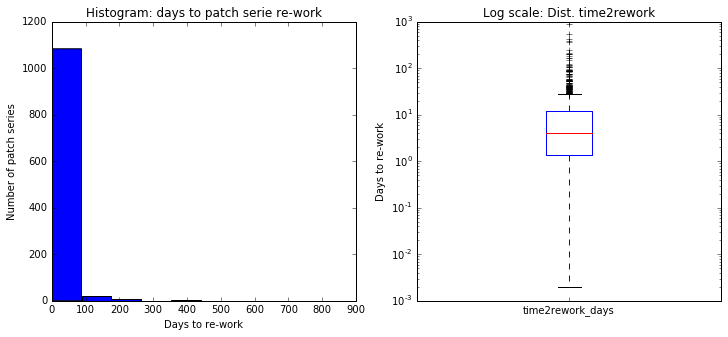

In [27]:
time2rework_list = list(time2rework)
time2rework_df = DataFrame(time2rework_list, columns=["patch_serie", "version", "rework_time", "last_version_activity", "time2rework"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2rework_df["time2rework_days"] = (time2rework_df["time2rework"]/3600)/24


hist_chart = time2rework_df["time2rework_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2rework_df["time2rework_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to re-work")
hist_chart.set_ylabel("Number of patch series")
hist_chart.set_title("Histogram: days to patch serie re-work")

boxplot_chart.set_ylabel("Days to re-work")
boxplot_chart.set_title("Log scale: Dist. time2rework")

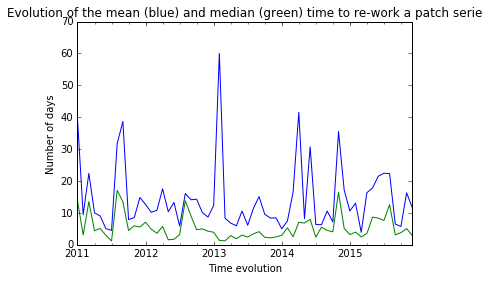

In [28]:
mean_time2rework = time2rework_df.set_index("rework_time").resample('M', how={"time2rework_days":np.mean})
median_time2rework = time2rework_df.set_index("rework_time").resample('M', how={"time2rework_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
time2reworkTS = Series(mean_time2rework["time2rework_days"], index=dates)
time2rework_medianTS = Series(median_time2rework["time2rework_days"], index=dates)

time2reworkTS_chart = time2reworkTS.plot()
time2rework_medianTS.plot()
time2reworkTS_chart.set_xlabel("Time evolution")
time2reworkTS_chart.set_ylabel("Number of days")
time2reworkTS_chart.set_title("Evolution of the mean (blue) and median (green) time to re-work a patch serie")

## Cycle time

In [29]:
query = """ SELECT p1.ps_id as patch_serie,
                   p1.version as version,
                   p1.date as cycle1,
                   p2.date as cycle2,
                   timestampdiff(SECOND, p1.date, p2.date) as time2newcycle
            FROM list.patch_series_version p1,
                list.patch_series_version p2
            WHERE p1.ps_id = p2.ps_id AND 
                  p1.version = p2.version -1 
            HAVING time2newcycle >= 0 and time2newcycle<1000*3600*24
            ORDER BY p1.ps_id """
time2newcycle = execute_query(cursor, query)

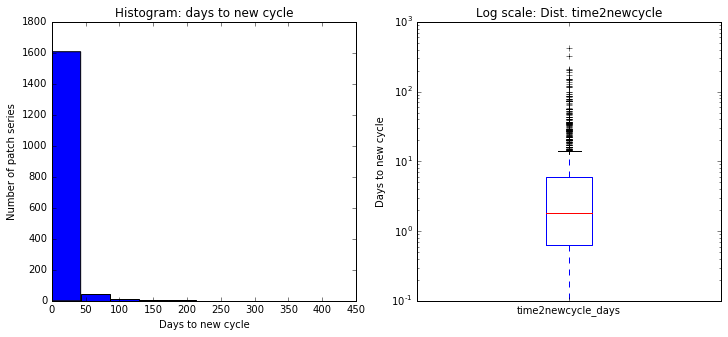

In [30]:
time2newcycle_list = list(time2newcycle)
time2newcycle_df = DataFrame(time2newcycle_list, columns=["patch_serie", "version", "cycle1", "cycle2", "time2newcycle"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2newcycle_df["time2newcycle_days"] = (time2newcycle_df["time2newcycle"]/3600)/24


hist_chart = time2newcycle_df["time2newcycle_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2newcycle_df["time2newcycle_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to new cycle")
hist_chart.set_ylabel("Number of patch series")
hist_chart.set_title("Histogram: days to new cycle")

boxplot_chart.set_ylabel("Days to new cycle")
boxplot_chart.set_title("Log scale: Dist. time2newcycle")

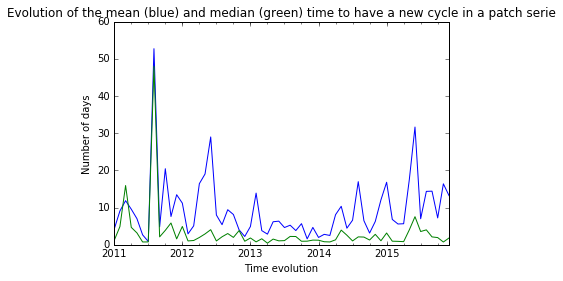

In [31]:
mean_time2newcycle = time2newcycle_df.set_index("cycle2").resample('M', how={"time2newcycle_days":np.mean})
median_time2newcycle = time2newcycle_df.set_index("cycle2").resample('M', how={"time2newcycle_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
time2newcycleTS = Series(mean_time2newcycle["time2newcycle_days"], index=dates)
time2newcycle_medianTS = Series(median_time2newcycle["time2newcycle_days"], index=dates)

time2newcycleTS_chart = time2newcycleTS.plot()
time2newcycle_medianTS.plot()
time2newcycleTS_chart.set_xlabel("Time evolution")
time2newcycleTS_chart.set_ylabel("Number of days")
time2newcycleTS_chart.set_title("Evolution of the mean (blue) and median (green) time to have a new cycle in a patch serie")

## Time to first review

Either this is a patch or a patch serie, this analysis is focused at the level of patch. This ignores all of the patches that are not reviewed.
At the level of 'flags', this counts the time between a patch is sent till a 'Reviewed-by' flag appears.

Some issues found:
*TODO

Assumption:
* Let's ignore first time reviews, so let's analyze only those times whose time to review is greater than 0 and when a patch has more than 1 review, selecting the minimum time among them. In this way, we'll avoid to have more than one repeated review.


In [32]:
query = """ SELECT p.subject as subject,
                   p.date as sent_date,
                   f.flag as flag,
                   f.date as reviewed_date,
                   TIMESTAMPDIFF(SECOND, p.date, min(f.date)) as time2review
            FROM list.patches p,
                list.flags f
            WHERE p.id = f.patch_id  and
                  f.flag='Reviewed-by' 
            GROUP BY p.subject 
            HAVING TIMESTAMPDIFF(SECOND, p.date, min(f.date)) > 0 and TIMESTAMPDIFF(SECOND, p.date, min(f.date));
        """
time2review = execute_query(cursor, query)

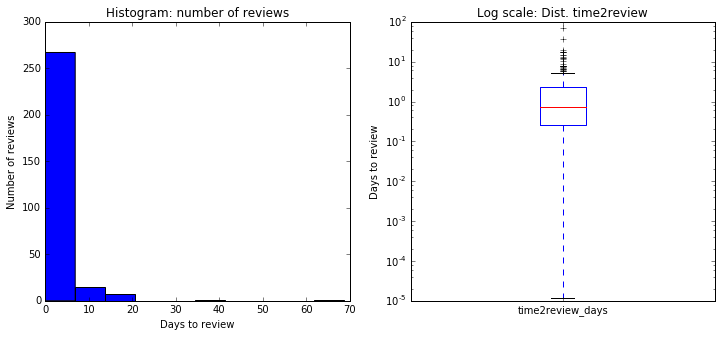

In [33]:
time2review_list = list(time2review)
time2review_df = DataFrame(time2review_list, columns=["subject", "date", "flag", "review_time", "time2review"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2review_df["time2review_days"] = (time2review_df["time2review"]/3600)/24


hist_chart = time2review_df["time2review_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2review_df["time2review_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to review")
hist_chart.set_ylabel("Number of reviews")
hist_chart.set_title("Histogram: number of reviews")

boxplot_chart.set_ylabel("Days to review")
boxplot_chart.set_title("Log scale: Dist. time2review")

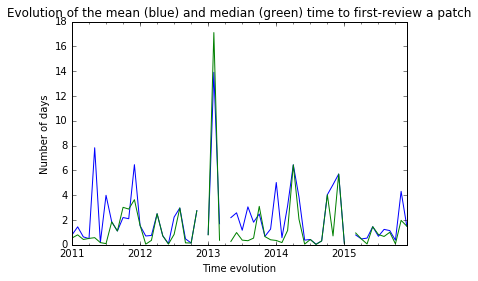

In [34]:
mean_time2review = time2review_df.set_index("review_time").resample('M', how={"time2review_days":np.mean})
median_time2review = time2review_df.set_index("review_time").resample('M', how={"time2review_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
time2reviewTS = Series(mean_time2review["time2review_days"], index=dates)
time2review_medianTS = Series(median_time2review["time2review_days"], index=dates)

time2reviewTS_chart = time2reviewTS.plot()
time2review_medianTS.plot()
time2reviewTS_chart.set_xlabel("Time evolution")
time2reviewTS_chart.set_ylabel("Number of days")
time2reviewTS_chart.set_title("Evolution of the mean (blue) and median (green) time to first-review a patch")

## Time to ack

In [35]:
query = """ SELECT t1.ps_id as patch_serie,
                   t1.first_patch_date,
                   f.flag as flag,
                   f.date as acked_date,
                   TIMESTAMPDIFF(SECOND, t1.first_patch_date, min(f.date)) as time2ack
            FROM list.patches p,
                list.flags f,
                 (select psv.ps_id,
                         p.id as patch_id, 
                         min(psv.date) as first_patch_date
                  from list.patch_series_version psv,
                      list.patches p
                  where p.ps_version_id=psv.id
                  group by psv.ps_id) t1
            WHERE p.id = f.patch_id  and
                  f.flag='Acked-by' and
                  p.id = t1.patch_id
            GROUP BY t1.ps_id 
  HAVING TIMESTAMPDIFF(SECOND, t1.first_patch_date, min(f.date)) > 0 and TIMESTAMPDIFF(SECOND, t1.first_patch_date, min(f.date))
        """
time2ack = execute_query(cursor, query)

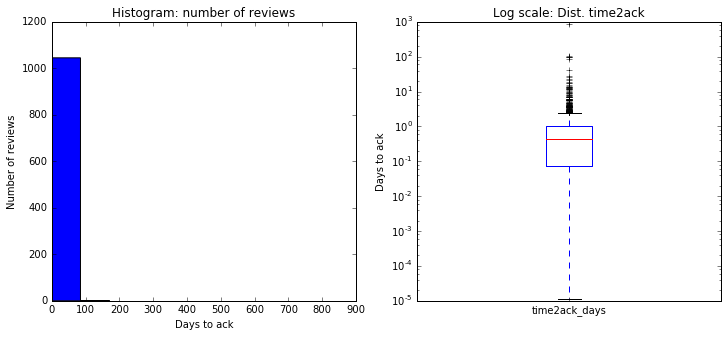

In [36]:
time2ack_list = list(time2ack)
time2ack_df = DataFrame(time2ack_list, columns=["subject", "date", "flag", "ack_time", "time2ack"])
fig, axs = plt.subplots(1,2, figsize=(12,5))


#Migrate seconds to days
time2ack_df["time2ack_days"] = (time2ack_df["time2ack"]/3600)/24


hist_chart = time2ack_df["time2ack_days"].plot(kind="hist", ax=axs[0])
boxplot_chart = time2ack_df["time2ack_days"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Days to ack")
hist_chart.set_ylabel("Number of reviews")
hist_chart.set_title("Histogram: number of reviews")

boxplot_chart.set_ylabel("Days to ack")
boxplot_chart.set_title("Log scale: Dist. time2ack")

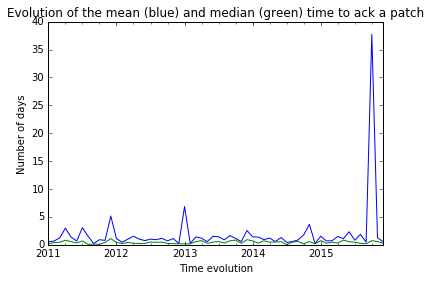

In [37]:
mean_time2ack = time2ack_df.set_index("ack_time").resample('M', how={"time2ack_days":np.mean})
median_time2ack = time2ack_df.set_index("ack_time").resample('M', how={"time2ack_days":np.median})
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-
time2ackTS = Series(mean_time2ack["time2ack_days"], index=dates)
time2ack_medianTS = Series(median_time2ack["time2ack_days"], index=dates)

time2ackTS_chart = time2ackTS.plot()
time2ack_medianTS.plot()
time2ackTS_chart.set_xlabel("Time evolution")
time2ackTS_chart.set_ylabel("Number of days")
time2ackTS_chart.set_title("Evolution of the mean (blue) and median (green) time to ack a patch")

# 3) BACKLOG ANALYSIS

Metrics to retrieve:
* Review (of series/patch) completed: all of the patch series merged
* Review (of series/patch) active: patches that were recently reviewed, we'll take the last 7 days as a potential timeframe.
* Review (of series/patch) stalled: patches older than 1 year
* Review (of series/patch) ongoing: patches younger than 1 year. This would include the active reviews.


## Reviews completed

In [38]:
# List of the most recent and completed reviews up to the date of this analysis
query = """ SELECT distinct ps.id as patch_serie, 
                   ps.subject, 
                   MAX(c.committer_date) as merge_time
            FROM list.patch_series ps,
                 list.patch_series_version psv,
                list.patches p,
                list.commits c
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND p.commit_id = c.id 
            GROUP BY ps.id 
            ORDER BY merge_time desc """
completed_reviews_list = execute_query(cursor, query)

In [39]:
completed_reviews = list(completed_reviews_list)
completed_reviews_df = DataFrame(completed_reviews, columns=["patch_serie", "subject", "merge_time"])
completed_reviews_df

patch_serie                                            subject  \
0           15726                   vhost: cross-endian code cleanup   
1           15860  net: ethernet: davicom: fix devicetree irq res...   
2           15964  fmvj18x_cs: fix incorrect indexing of dev->dev...   
3           15887  net: ti: netcp: restore get/set_pad_info() fun...   
4           15949  net: ti: netcp: restore get/set_pad_info() fun...   
5           15955  MAINTAINERS: Drop myself as xen netback mainta...   
6           15946         sctp: Fix port hash table size computation   
7           15957  Bluetooth: hci_core: Avoid mixing up req_compl...   
8           15956         net: bcmgenet: Fix internal PHY link state   
9           15873  af_unix: Don't use continue to re-execute unix...   
10          15954  unix_diag: fix incorrect sign extension in uni...   
11          15952  ser_gigaset: use container_of() instead of detour   
12          15938            cxgb3: fix up vpd strings for kstrto*()   
13          15936                         tipc: unlock in error path   
14          15929       rtnl: RTM_GETNETCONF: fix wrong return value   
15          15945  USB: cdc_subset: only build when one driver is...   
16          15893                 ath10k: fix erroneous return value   
17          15894                iwlwifi: fix erroneous return value   
18          15933              appletalk: fix erroneous return value   
19          15934              net: caif: fix erroneous return value   
20          15935   mISDN: prevent possible NULL pointer dereference   
21          15864   net: cavium: liquidio: Return correct error code   
22          15876                 bonding: Return correct error code   
23          15943                   lance: Return correct error code   
24          15921   et131x: check return value of dma_alloc_coherent   
25          15925                 net: thunderx: Miscellaneous fixes   
26          15922      tcp: correctly crypto_alloc_hash return check   
27          15919      phy: marvell: Fix and unify reg-init behavior   
28          15914  ravb: Update DT binding example for final CPG/...   
29          15916              l2tp: Fix error creating L2TP tunnels   
...           ...                                                ...   
8665         3780                 ehea: Increase the skb array usage   
8666         3753        net: ppp: use {get,put}_unaligned_be{16,32}   
8667         3761  net/r8169: Update the function of parsing firm...   
8668         3759  CAIF: Fix IPv6 support in receive path for GPR...   
8669         3767  mlx4: Call alloc_etherdev to allocate RX and T...   
8670         3766                 net: Add alloc_netdev_mqs function   
8671         3777  caif: don't set connection request param size ...   
8672         3770                                   qlcnic:bug fixes   
8673         4047  e1000: power off PHY after reset when interfac...   
8674         3764  offloading: Accept NETIF_F_HW_CSUM for all pro...   
8675         3762  net/sock.h: make some fields private to fix ke...   
8676         3763       net: fix kernel-doc warning in core/filter.c   
8677         3756  hamradio: Resolve memory leak due to missing f...   
8678         3757  Madge Ambassador ATM Adapter driver: Always re...   
8679         3752  Re: spurious netconsole: network logging stopp...   
8680         3750  netfilter: fix the race when initializing nf_c...   
8681         3749  net: r6040: Return proper error for r6040_init...   
8682         3748  net: ixp4xx_eth: Return proper error for eth_i...   
8683        15209                             Coding Style Cleanning   
8684         3744     ipv4/route.c: respect prefsrc for local routes   
8685         3746     net: typos in comments in include/linux/igmp.h   
8686         3740  smsc-ircc2: Fix section mismatch derived from ...   
8687         3741  depca: Fix section mismatch derived from depca...   
8688         3739  ksz884x: Fix section mismat

In [40]:
# Total number of completed reviews up to the date of this analysis
query = """ SELECT count(distinct(ps.id)) as merged_patch_series
            FROM list.patch_series ps,
                 list.patch_series_version psv,
				list.patches p,
                list.commits c
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND p.commit_id = c.id 
            """
total_completed_reviews = execute_query(cursor, query)

In [41]:
total_completed_reviews

((8695L,),)

## Reviews active

In [42]:
# List of recent reviewed patch series but not merged.
query = """ SELECT DISTINCT ps.id as reviewed_patch_serie,
                   ps.subject,
                   max(f.date) as last_reviewed_date
            FROM list.patch_series ps, 
                list.patch_series_version psv, 
               list.patches p, 
                list.flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM list.patch_series ps,
                      list.patch_series_version psv,
                      list.patches p,
                      list.commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date BETWEEN DATE_SUB(NOW(), INTERVAL 540 DAY) AND NOW() 
            GROUP BY ps.id
            ORDER BY f.date desc """ # INITIAL VALUE OF 420 DAYS
recent_reviews = execute_query(cursor, query)

In [43]:
recent_reviews_list = list(recent_reviews)
recent_reviews_df = DataFrame(recent_reviews_list, columns=["patch_serie", "subject", "last_reviewed_date"])
recent_reviews_df

patch_serie                                            subject  \
0          16002  asm-generic: remove old nonatomic-io wrapper f...   
1          15858                  Add Ethernet support on STM32F429   
2          16000  [V3] mt7601u: do not free dma_buf when ivp all...   
3          15999  [V3] mt7601u: do not free dma_buf when ivp all...   
4          15993        Convert network timestamps to be y2038 safe   
5          14744  Patchset enabling hardware based cross-timesta...   
6          15941                     mwifiex: Use to_delayed_work()   
7          15926  net: igmp: use IS_ENABLED(CONFIG_IP_MULTICAST)...   
8          15919      phy: marvell: Fix and unify reg-init behavior   
9          15914  ravb: Update DT binding example for final CPG/...   
10         15911  Kill useless *switch* defaults in the Renesas ...   
11         15916              l2tp: Fix error creating L2TP tunnels   
12         15879               ethtool per queue parameters support   
13         15893                 ath10k: fix erroneous return value   
14         15898  net: dsa: mv88e6xxx: Add support for Marvell 8...   
15         15892  net: hamradio: baycom_ser_fdx: Replace timeval...   
16         15881                     RFKill airplane-mode indicator   
17         15878    Add support for MICREL KSZ8795CLX 5-port switch   
18         15871  net: phy: dp83848: Add support for TI TLK10x E...   
19         15859  of: of_mdio: Add marvell,88e1145 to whitelist ...   
20         15857  rtlwifi: Fix improve function 'rtl_addr_delay(...   
21         15854  rtlwifi: Fix improve function 'rtl_addr_delay(...   
22         15853              rtlwifi: Fix reusable codes in core.c   
23         15855              rtlwifi: Fix reusable codes in core.c   
24         15839                          mac80211: fix memory leak   
25         15826            netfilter: h323: avoid potential attack   
26         15814  net_sched: drr: check for NULL pointer in drr_...   
27         15813  net: mv643xx_eth: fix packet corruption with T...   
28         15792                            mac802154: Use skcipher   
29         15806  brcmfmac: sdio: Increase the default timeouts ...   
..           ...                                                ...   
94         14655  net: phy: Pass mdix ethtool setting through to...   
95         14648     9p/trans_virtio: reset virtio device on remove   
96         14634            net: systemport: Use eth_hw_addr_random   
97         14631  dsa: mv88e6352/mv88e6xxx: Add support for Marv...   
98         14605  net: phy: add dependency on HAS_IOMEM to MDIO_...   
99         14597  bonding: "primary_reselect" with "failure" is ...   
100        14522  Fix Ethernet jumbo frames support for Armada 3...   
101        14590  igb: Use ARRAY_SIZE instead fo sizeof(a)/sizeo...   
102        14582          xen-netfront: Remove the meaningless code   
103        11997  net/phy: tune get_phy_c45_ids to support more ...   
104        14566                ppp: remove NULL check before kfree   
105        14540                   ssb: remove unncessary out label   
106        14537        ixgbe: use kzalloc for allocating one thing   
107        14523                                      xen: Clean up   
108        14492   ethernet/sfc: mark state UNINIT after unregister   
109        14499                net: replace if()/BUG with BUG_ON()   
110        14466  tipc: disconnect socket directly after probe f...   
111        14460         net: phy: dp83867: Fix device tree entries   
112        14442         net/phy: micrel: Center FLP timing at 16ms   
113        14435                                  net/xen: Clean up   
114        14405  xen-netfront: properly destroy queues when rem...   
115        14381  Fix couple of issues with 'ethtool' get/set API's   
116        14363       Fix an issue with 'ethtool' configuring PHYs   
117        14352                     ixgbe: Add new ndo to trust VF   
118        14351             

In [44]:
query = """ SELECT COUNT(DISTINCT(ps.id)) as reviewed_patch_serie
            FROM list.patch_series ps, 
				 list.patch_series_version psv, 
				 list.patches p, 
				 list.flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM list.patch_series ps,
						list.patch_series_version psv,
						list.patches p,
						list.commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date BETWEEN DATE_SUB(NOW(), INTERVAL 540 DAY) AND NOW() """ # INITIAL VALUE OF 60 DAYS
total_recent_reviews = execute_query(cursor, query)

In [45]:
total_recent_reviews

((124L,),)

## Reviews ongoing

In [46]:
# List of last year reviewed patch series but not merged (and not recent reviewed)
query = """ SELECT DISTINCT ps.id as reviewed_patch_serie,
                   ps.subject,
                   max(f.date) as last_reviewed_date
            FROM list.patch_series ps, 
				 list.patch_series_version psv, 
				 list.patches p, 
				 list.flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM list.patch_series ps,
						list.patch_series_version psv,
                        list.patches p,
                        list.commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date BETWEEN DATE_SUB(NOW(), INTERVAL 365 DAY) AND DATE_SUB(NOW(), INTERVAL 60 DAY)
            GROUP BY ps.id
            ORDER BY f.date desc """ # INITIAL VALUE OF 60 DAYS
last_year_reviews = execute_query(cursor, query)

In [47]:
last_year_reviews_list = list(last_year_reviews)
last_year_reviews_df = DataFrame(last_year_reviews_list, columns=["patch_serie", "subject", "last_reviewed_date"])
last_year_reviews_df

patch_serie                                            subject  \
0         16002  asm-generic: remove old nonatomic-io wrapper f...   
1         15858                  Add Ethernet support on STM32F429   
2         15999  [V3] mt7601u: do not free dma_buf when ivp all...   
3         16000  [V3] mt7601u: do not free dma_buf when ivp all...   
4         15993        Convert network timestamps to be y2038 safe   
5         14744  Patchset enabling hardware based cross-timesta...   
6         15941                     mwifiex: Use to_delayed_work()   
7         15926  net: igmp: use IS_ENABLED(CONFIG_IP_MULTICAST)...   
8         15919      phy: marvell: Fix and unify reg-init behavior   
9         15914  ravb: Update DT binding example for final CPG/...   
10        15911  Kill useless *switch* defaults in the Renesas ...   
11        15916              l2tp: Fix error creating L2TP tunnels   
12        15879               ethtool per queue parameters support   
13        15893                 ath10k: fix erroneous return value   
14        15898  net: dsa: mv88e6xxx: Add support for Marvell 8...   
15        15892  net: hamradio: baycom_ser_fdx: Replace timeval...   
16        15881                     RFKill airplane-mode indicator   
17        15878    Add support for MICREL KSZ8795CLX 5-port switch   
18        15871  net: phy: dp83848: Add support for TI TLK10x E...   
19        15859  of: of_mdio: Add marvell,88e1145 to whitelist ...   
20        15857  rtlwifi: Fix improve function 'rtl_addr_delay(...   
21        15854  rtlwifi: Fix improve function 'rtl_addr_delay(...   
22        15853              rtlwifi: Fix reusable codes in core.c   
23        15855              rtlwifi: Fix reusable codes in core.c   
24        15839                          mac80211: fix memory leak   
25        15826            netfilter: h323: avoid potential attack   
26        15814  net_sched: drr: check for NULL pointer in drr_...   
27        15813  net: mv643xx_eth: fix packet corruption with T...   
28        15792                            mac802154: Use skcipher   
29        15806  brcmfmac: sdio: Increase the default timeouts ...   
30        15802  net: fec: use CONFIG_ARM instead of CONFIG_ARC...   
31        15726                   vhost: cross-endian code cleanup   
32        15759                            Netfilter fixes for net   
33        15753     can: c_can: add xceiver enable/disable support   
34        15719  net: fec: Reset ethernet PHY whenever the enet...   
35        15710             vhost: move is_le setup to the backend   
36        15706  perf tools: Bugfix, BPF improvement and perf r...   
37        15656  netfilter: nf_conntrack: use safer way to lock...   
38        15670           net: add per device sg_max_frags for skb   
39        15579               ipv6/addrlabel: fix ip6addrlbl_get()   
40        15555  Octeon: Fix logic for waking octoen ethernet t...   
41        15545    gianfar: Don't enable RX Filer if not supported   
42        15464                  Add virtio transport for AF_VSOCK   
43        15503  mm: memcontrol: account socket memory in unifi...   
44        15488                VSOCK: fix returnvar.cocci warnings   
45        15427  mm: memcontrol: account socket memory in unifi...   
46        15366  mm: memcontrol: account socket memory in unifi...   
47        15358  arm64: bpf: correct JIT stack setup and make i...   
48        15285             vhost: move is_le setup to the backend   
49        15365         net: phy: vitesse: add support for VSC8601   
50        15364  net: phy: at803x: support interrupt on 8030 an...   
51        15348  arm64: bpf: add BPF_ST and BPF_XADD instructio...   
52        15336  tree wide: Use kvfree() than conditional kfree...   
53        14130  ipv4: add option to drop unicast encapsulated ...   
54        15306  i40e: Look up MAC address in Open Firmware or ...   
55        15236                                 e1000e msi-x fixes   
56        1526

In [48]:
query = """ SELECT COUNT(DISTINCT(ps.id)) as reviewed_patch_serie
            FROM list.patch_series ps, 
                 list.patch_series_version psv, 
				 list.patches p, 
                 list.flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM list.patch_series ps,
                        list.patch_series_version psv,
                        list.patches p,
                        list.commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date BETWEEN DATE_SUB(NOW(), INTERVAL 365 DAY) AND DATE_SUB(NOW(), INTERVAL 60 DAY) """ # INITIAL VALUE OF 60 DAYS
total_last_year_reviews = execute_query(cursor, query)

In [49]:
total_last_year_reviews

((57L,),)

## Reviews stalled

In [50]:
# Stalled list of reviews: those with review activity and older than one year
query = """ SELECT DISTINCT ps.id as reviewed_patch_serie,
                   ps.subject,
                   max(f.date) as last_reviewed_date
            FROM list.patch_series ps, 
				 list.patch_series_version psv, 
				 list.patches p, 
				 list.flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM list.patch_series ps,
						list.patch_series_version psv,
                        list.patches p,
                        list.commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date < DATE_SUB(NOW(), INTERVAL 365 DAY)
            GROUP BY ps.id
            ORDER BY f.date desc """ 
stalled_reviews = execute_query(cursor, query)

In [51]:
stalled_reviews_list = list(stalled_reviews)
stalled_reviews_df = DataFrame(stalled_reviews_list, columns=["patch_serie", "subject", "last_reviewed_date"])
stalled_reviews_df

patch_serie                                            subject  \
0          15251  commit e53376bef2cd97d3e3f61fdc677fb8da7d03d0d...   
1          15216  VSOCK: sock_put wasn't safe to call in interru...   
2          15215     net: phy: dp83848: Add TI DP83848 Ethernet PHY   
3          15174    xen-netfront: update num_queues to real created   
4          15192                Netfilter/IPVS updates for net-next   
5          15137       bridge/netfilter: avoid unused label warning   
6          15124                   net: dsa: better error reporting   
7          15122  net: dsa: switch to devm_ calls and remove kfr...   
8          15120    net: dsa: add missing dsa_switch mdiobus remove   
9          15121              net: dsa: complete dsa_switch_destroy   
10         15097                        net: assorted y2038 changes   
11         15098  Add support for Broadcom's iProc MDIO and Cygn...   
12         15085        y2038 conversion for ntp/pps and sfc driver   
13         15049       Phy, mdiobus, and netdev struct device fixes   
14         15065    phy: marvell: add link partner advertised modes   
15         15008  geneve: remove use of internal IP header when ...   
16         15009             geneve: restore vlan bits in xmit path   
17         15012  iplink_geneve: add UDP destination port config...   
18         15013         Replace get_seconds with ktime_get_seconds   
19         14952  vxlan: Refactor vxlan_udp_encap_recv() to kill...   
20         14946  net: tipc: fix stall during bclink wakeup proc...   
21         14949  device property: Don't overwrite addr when fai...   
22         14928  phylib: fix device deletion order in mdiobus_u...   
23         14905     lib/Makefile: remove CONFIG_AVERAGE build rule   
24         14893                            RDS: Assorted bug fixes   
25         14883             net: bcmgenet: fix uncleaned dma flags   
26         14838                  Enable smsc911x for use with ACPI   
27         14824         Use correctly the Xen memory terminologies   
28         14772         MIPS: Remove all the uses of custom gpio.h   
29         14782  net: dsa: mv88e6xxx: call _mv88e6xxx_stats_wai...   
..           ...                                                ...   
422         4608                  minor cleanup to net_namespace.c.   
423         4604  ipv4: Call fib_select_default() only when actu...   
424         4351  ethtool: __ethtool_set_sg: check for function ...   
425         3831                         xen network backend driver   
426         4255                          tg3: Remove 5750 PCI code   
427         4254    tg3: Move tg3_init_link_config to tg3_phy_probe   
428         4253                  tg3: Refine VAux decision process   
429         4252                 tg3: cleanup pci device table vars   
430         4251     tg3: Add code to verify RODATA checksum of VPD   
431         4250                            tg3: Fix NVRAM selftest   
432         4249             tg3: Add missed 5719 workaround change   
433         4204  Issue NETDEV_CHANGE notification when bridge c...   
434         4198  ipv4: Set rt->rt_iif more sanely on output rou...   
435         4197  ipv4: Use passed-in protocol in ip_route_newpo...   
436         4196  ipv4: Get peer more cheaply in rt_init_metrics().   
437         4186  netlink: kill eff_cap from struct netlink_skb_...   
438         4132       sched: QFQ - quick fair queue scheduler (v2)   
439         4077                          e1000: fix sparse warning   
440         3933   net: Support compat SIOCGETVIFCNT ioctl in ipv4.   
441         3934  net: Provide compat support for SIOCGETMIFCNT_...   
442         3906  net: Add compat ioctl support for the ipv4 mul...   
443         3860                 net: Unified offload configuration   
444         3834                    net: dev_close_many() is static   
445         3833                        netfilter: netfilter update   
446         3830  af_unix: co

In [52]:
query = """ SELECT COUNT(DISTINCT(ps.id)) as reviewed_patch_serie
            FROM list.patch_series ps, 
				 list.patch_series_version psv, 
                 list.patches p, 
                 list.flags f 
            WHERE ps.id = psv.ps_id AND 
                  psv.id = p.ps_version_id AND 
                  f.patch_id = p.id AND 
                  f.flag='Reviewed-by' AND 
                  ps.id not in 
                  (SELECT COUNT(DISTINCT(ps.id)) as merged_patch_series
                   FROM list.patch_series ps,
						list.patch_series_version psv,
						list.patches p,
                        list.commits c
                   WHERE ps.id = psv.ps_id AND
                         psv.id = p.ps_version_id AND
                         p.commit_id = c.id) AND 
                  f.date < DATE_SUB(NOW(), INTERVAL 365 DAY)"""
total_stalled_reviews = execute_query(cursor, query)

In [53]:
int(total_stalled_reviews[0][0])
#total_stalled_reviews


452

# 4) PATCH SERIES COMPLEXITY ANALYSIS

Metrics to retrieve:
* Number of versions per patch serie
* From patches merged: check number of 'touched' files plus added and removed lines
* Comments received per patch
* Number of patches per patch serie

## Number of versions per patch serie

In [54]:
query = """ SELECT ps_id as patch_serie,
                   COUNT(DISTINCT(version)) as versions,
                   MIN(date) as patch_serie_first_date
            FROM list.patch_series_version
            GROUP BY ps_id """
iterations = execute_query(cursor, query)

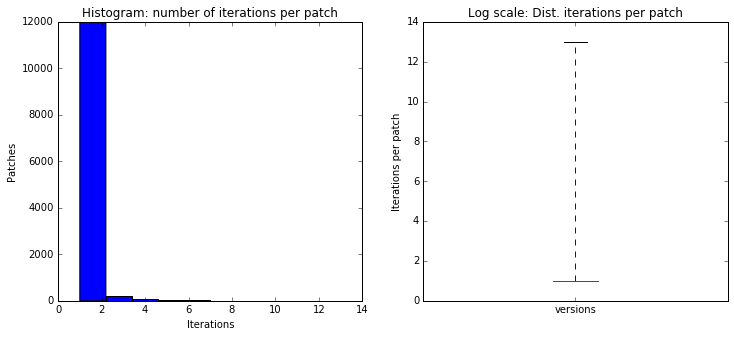

In [55]:
iterations_list = list(iterations)
iterations_df = DataFrame(iterations_list, columns=["patch_serie", "versions", "patch_serie_first_date"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = iterations_df["versions"].plot(kind="hist", ax=axs[0])
boxplot_chart = iterations_df["versions"].plot(kind="box", ax=axs[1])

#chart labels
hist_chart.set_xlabel("Iterations")
hist_chart.set_ylabel("Patches")
hist_chart.set_title("Histogram: number of iterations per patch")

boxplot_chart.set_ylabel("Iterations per patch")
boxplot_chart.set_title("Log scale: Dist. iterations per patch")

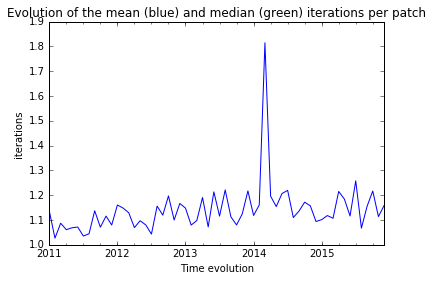

In [56]:
mean_iterations = iterations_df.set_index("patch_serie_first_date").resample('M', how={"versions":np.mean})
median_iterations = iterations_df.set_index("patch_serie_first_date").resample('M', how={"versions":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2010-10 and ending in 2015-08
iterationsTS = Series(mean_iterations["versions"], index=dates)
iterations_medianTS = Series(median_iterations["versions"], index=dates)

iterations_chart = iterationsTS.plot()
iterations_medianTS.plot()
iterations_chart.set_xlabel("Time evolution")
iterations_chart.set_ylabel("iterations")
iterations_chart.set_title("Evolution of the mean (blue) and median (green) iterations per patch")

## Comments received per patch serie

In [63]:
# Let's calculate evolution of comments in general when they were sent

query = """ SELECT MIN(psv.date) as patch_serie_first_date,
                   ps_id as patch_serie,
                   count(distinct(c.id)) as comments
            FROM list.patch_series_version psv,
                 list.patches p,
                 list.comments c 
            WHERE psv.id = p.ps_version_id and 
                  p.id = c.patch_id and
                  year(psv.date) > 2010 and
                  year(psv.date) < 2016
            GROUP BY ps_id   
        """
comments = execute_query(cursor, query)

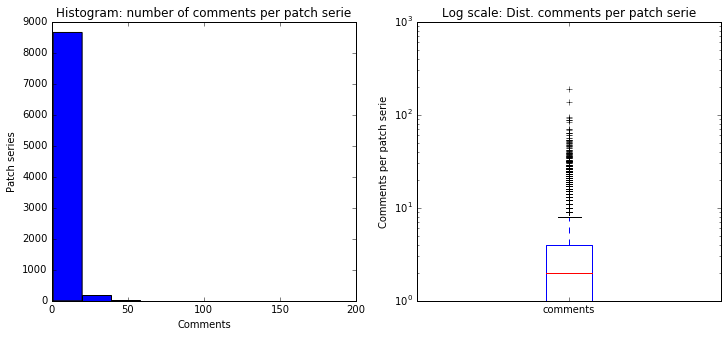

In [64]:
comments_list = list(comments)
comments_df = DataFrame(comments_list, columns=["patch_serie_first_date", "patch_serie", "comments"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = comments_df["comments"].plot(kind="hist", ax=axs[0])
boxplot_chart = comments_df["comments"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("Comments")
hist_chart.set_ylabel("Patch series")
hist_chart.set_title("Histogram: number of comments per patch serie")

boxplot_chart.set_ylabel("Comments per patch serie")
boxplot_chart.set_title("Log scale: Dist. comments per patch serie")


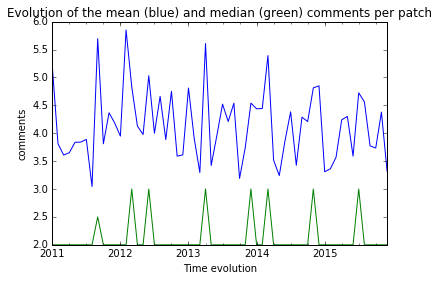

In [141]:
# Comments per patch serie in mean. This is also time series distributed to check if there are more comments per patch series in mean and median
mean_comments = comments_df.set_index("patch_serie_first_date").resample('M', how={"comments":np.mean})
median_comments = comments_df.set_index("patch_serie_first_date").resample('M', how={"comments":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
commentsTS = Series(mean_comments["comments"], index=dates)
comments_medianTS = Series(median_comments["comments"], index=dates)

comments_chart = commentsTS.plot()
comments_medianTS.plot()
comments_chart.set_xlabel("Time evolution")
comments_chart.set_ylabel("comments")
comments_chart.set_title("Evolution of the mean (blue) and median (green) comments per patch")

## Number of patches per patch serie

In [142]:
query = """ SELECT  distinct psv.ps_id as patch_serie,  
                   psv.date as first_send, 
                   max(t.patches) as numpatches 
             FROM list.patch_series_version psv, 
                   list.patches p, 
                     (SELECT psv.ps_id, 
                             p.ps_version_id, 
                             count(distinct(p.id)) as patches 
                      FROM list.patch_series_version psv, 
						   list.patches p 
                      WHERE psv.id = p.ps_version_id  
                      GROUP BY psv.ps_id, 
                               p.ps_version_id) t 
              WHERE psv.ps_id = t.ps_id AND 
                    p.ps_version_id=t.ps_version_id AND 
                    psv.id = p.ps_version_id 
              GROUP BY psv.ps_id
          """
patches_ps = execute_query(cursor, query)

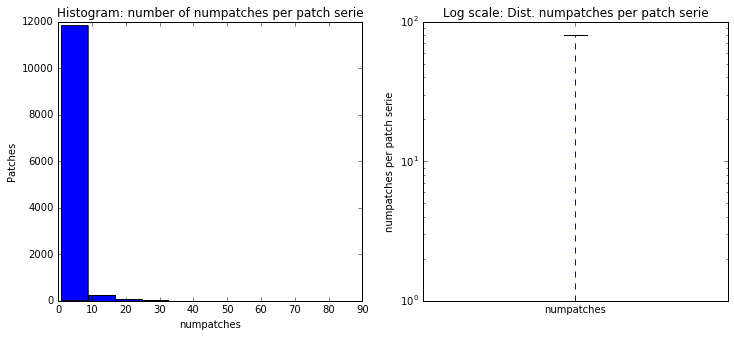

In [143]:
numpatches_list = list(patches_ps)
numpatches_df = DataFrame(numpatches_list, columns=["patch_serie", "first_send", "numpatches"])

fig, axs = plt.subplots(1,2, figsize=(12,5))

hist_chart = numpatches_df["numpatches"].plot(kind="hist", ax=axs[0])
boxplot_chart = numpatches_df["numpatches"].plot(kind="box", ax=axs[1], logy=True)

#chart labels
hist_chart.set_xlabel("numpatches")
hist_chart.set_ylabel("Patches")
hist_chart.set_title("Histogram: number of numpatches per patch serie")

boxplot_chart.set_ylabel("numpatches per patch serie")
boxplot_chart.set_title("Log scale: Dist. numpatches per patch serie")


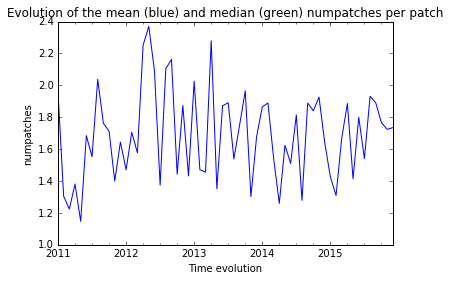

In [75]:
# numpatches per patch serie in mean. This is also time series distributed to check if there are more numpatches per patch series in mean and median
mean_numpatches = numpatches_df.set_index("first_send").resample('M', how={"numpatches":np.mean})
median_numpatches = numpatches_df.set_index("first_send").resample('M', how={"numpatches":np.median})

dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2011-01 and ending in 2015-12
numpatchesTS = Series(mean_numpatches["numpatches"], index=dates)
numpatches_medianTS = Series(median_numpatches["numpatches"], index=dates)

numpatches_chart = numpatchesTS.plot()
numpatches_medianTS.plot()
numpatches_chart.set_xlabel("Time evolution")
numpatches_chart.set_ylabel("numpatches")
numpatches_chart.set_title("Evolution of the mean (blue) and median (green) numpatches per patch")

# 6) ANALYSIS

## Splitting by date

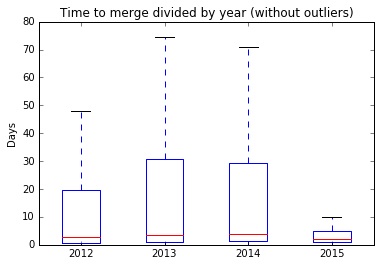

In [78]:
# Taking time2merge dataframe
time2merge_2015 = time2merge_df[time2merge_df["first_patch_date"] >= '2015-01-01']
time2merge_2015 = time2merge_df[time2merge_df["first_patch_date"] >= '2016-01-01']

time2merge_2014 = time2merge_df[time2merge_df["first_patch_date"] >= '2014-01-01']
time2merge_2014 = time2merge_2014[time2merge_2014["first_patch_date"] < '2015-01-01']

time2merge_2013 = time2merge_df[time2merge_df["first_patch_date"] >= '2013-01-01']
time2merge_2013 = time2merge_2013[time2merge_2013["first_patch_date"] < '2014-01-01']

time2merge_2012 = time2merge_df[time2merge_df["first_patch_date"] >= '2012-01-01']
time2merge_2012 = time2merge_2012[time2merge_2012["first_patch_date"] < '2013-01-01']


data=[time2merge_2012["time2merge_days"], time2merge_2013["time2merge_days"], time2merge_2014["time2merge_days"], time2merge_2015["time2merge_days"]]

figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4], ['2012', '2013', '2014', '2015'])
pylab.title("Time to merge divided by year (without outliers)")
pylab.ylabel("Days")

### Splitting by semester and taking the time when the changeset was open

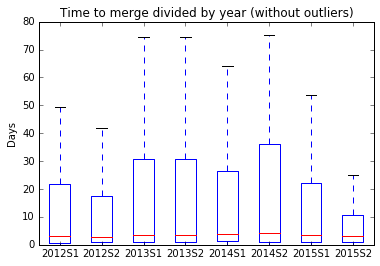

In [79]:
# Taking time2merge dataframe
time2merge_2015_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2015-07-01']
time2merge_2015_s2 = time2merge_2015_s2[time2merge_2015_s2["first_patch_date"] < '2016-01-01']
time2merge_2015_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2015-01-01']
time2merge_2015_s1 = time2merge_2015_s1[time2merge_2015_s1["first_patch_date"] < '2015-07-01']

time2merge_2014_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2014-07-01']
time2merge_2014_s2 = time2merge_2014_s2[time2merge_2014_s2["first_patch_date"] < '2015-01-01']
time2merge_2014_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2014-01-01']
time2merge_2014_s1 = time2merge_2014_s1[time2merge_2014_s1["first_patch_date"] < '2014-07-01']

time2merge_2013_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2013-01-01']
time2merge_2013_s2 = time2merge_2013_s2[time2merge_2013_s2["first_patch_date"] < '2014-01-01']
time2merge_2013_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2013-01-01']
time2merge_2013_s1 = time2merge_2013_s1[time2merge_2013_s1["first_patch_date"] < '2014-01-01']

time2merge_2012_s2 = time2merge_df[time2merge_df["first_patch_date"] >= '2012-07-01']
time2merge_2012_s2 = time2merge_2012_s2[time2merge_2012_s2["first_patch_date"] < '2013-01-01']
time2merge_2012_s1 = time2merge_df[time2merge_df["first_patch_date"] >= '2012-01-01']
time2merge_2012_s1 = time2merge_2012_s1[time2merge_2012_s1["first_patch_date"] < '2012-07-01']


data=[time2merge_2012_s1["time2merge_days"], time2merge_2012_s2["time2merge_days"], time2merge_2013_s1["time2merge_days"], time2merge_2013_s2["time2merge_days"], time2merge_2014_s1["time2merge_days"], time2merge_2014_s2["time2merge_days"], time2merge_2015_s1["time2merge_days"], time2merge_2015_s2["time2merge_days"]]

figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['2012S1', '2012S2', '2013S1', '2013S2', '2014S1', '2014S2', '2015S1', '2015S2'])
pylab.title("Time to merge divided by year (without outliers)")
pylab.ylabel("Days")

In [87]:
#time2merge_2015_s2 

### Splitting by semester and taking the time when the changeset was merged

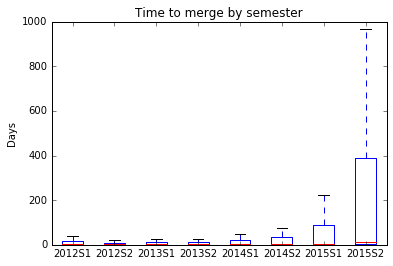

In [90]:
# Taking time2merge dataframe
time2merge_2015_s2 = time2merge_df[time2merge_df["merge_time"] >= '2015-07-01']
time2merge_2015_s2 = time2merge_2015_s2[time2merge_2015_s2["merge_time"] < '2016-01-01']
time2merge_2015_s1 = time2merge_df[time2merge_df["merge_time"] >= '2015-01-01']
time2merge_2015_s1 = time2merge_2015_s1[time2merge_2015_s1["merge_time"] < '2015-07-01']

time2merge_2014_s2 = time2merge_df[time2merge_df["merge_time"] >= '2014-07-01']
time2merge_2014_s2 = time2merge_2014_s2[time2merge_2014_s2["merge_time"] < '2015-01-01']
time2merge_2014_s1 = time2merge_df[time2merge_df["merge_time"] >= '2014-01-01']
time2merge_2014_s1 = time2merge_2014_s1[time2merge_2014_s1["merge_time"] < '2014-07-01']

time2merge_2013_s2 = time2merge_df[time2merge_df["merge_time"] >= '2013-01-01']
time2merge_2013_s2 = time2merge_2013_s2[time2merge_2013_s2["merge_time"] < '2014-01-01']
time2merge_2013_s1 = time2merge_df[time2merge_df["merge_time"] >= '2013-01-01']
time2merge_2013_s1 = time2merge_2013_s1[time2merge_2013_s1["merge_time"] < '2014-01-01']

time2merge_2012_s2 = time2merge_df[time2merge_df["merge_time"] >= '2012-07-01']
time2merge_2012_s2 = time2merge_2012_s2[time2merge_2012_s2["merge_time"] < '2013-01-01']
time2merge_2012_s1 = time2merge_df[time2merge_df["merge_time"] >= '2012-01-01']
time2merge_2012_s1 = time2merge_2012_s1[time2merge_2012_s1["merge_time"] < '2012-07-01']


data=[time2merge_2012_s1["time2merge_days"], time2merge_2012_s2["time2merge_days"], time2merge_2013_s1["time2merge_days"], time2merge_2013_s2["time2merge_days"], time2merge_2014_s1["time2merge_days"], time2merge_2014_s2["time2merge_days"], time2merge_2015_s1["time2merge_days"], time2merge_2015_s2["time2merge_days"]]

figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['2012S1', '2012S2', '2013S1', '2013S2', '2014S1', '2014S2', '2015S1', '2015S2'])
pylab.title("Time to merge by semester")
pylab.ylabel("Days")

## Splitting by number of patches in the patch serie

In [91]:
query = """ SELECT psv.ps_id as patch_serie,
                   TIMESTAMPDIFF(SECOND, MIN(psv.date), MAX(c.committer_date)) as time2merge,
                   MIN(psv.date) as first_patch_date, 
                   MAX(c.committer_date) as merge_time,
                   MAX(t.patches) as numpatches 
             FROM list.patch_series_version psv, 
				  list.patches p, 
                     (SELECT psv.ps_id, 
                             p.ps_version_id, 
                             count(*) as patches 
                      FROM list.patch_series_version psv, 
                           list.patches p 
                      WHERE psv.id = p.ps_version_id  
                      GROUP BY psv.ps_id, 
                               p.ps_version_id) t,
                   list.commits c
              WHERE psv.ps_id = t.ps_id AND 
                    p.ps_version_id=t.ps_version_id AND 
                    psv.id = p.ps_version_id AND
                    p.commit_id = c.id
              GROUP BY psv.ps_id 
              HAVING time2merge > 0 and time2merge < 1000*3600*24"""
time2merge_extra = execute_query(cursor, query)

In [92]:
time2merge_extra_list = list(time2merge_extra)
time2merge_extra_df = DataFrame(time2merge_extra_list, columns=["patch_serie", "time2merge", "first_patch_date", "merge_time", "numpatches"])
time2merge_extra_df["time2merge_days"] = (time2merge_extra_df["time2merge"]/3600)/24

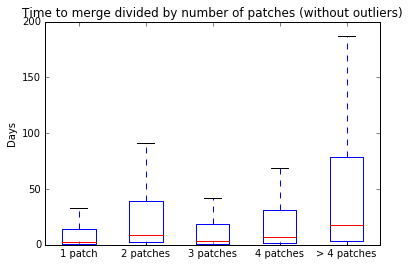

In [93]:
time2merge_extra_df_1patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==1]
time2merge_extra_df_2patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==2]
time2merge_extra_df_3patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==3]
time2merge_extra_df_4patch = time2merge_extra_df[time2merge_extra_df["numpatches"]==4]
time2merge_extra_df_5patch = time2merge_extra_df[time2merge_extra_df["numpatches"]>4]

data=[time2merge_extra_df_1patch["time2merge_days"], time2merge_extra_df_2patch["time2merge_days"], time2merge_extra_df_3patch["time2merge_days"],
      time2merge_extra_df_4patch["time2merge_days"], time2merge_extra_df_5patch["time2merge_days"]]
figure = pylab.boxplot(data, sym="")
ticks = pylab.xticks([1, 2, 3, 4, 5], ['1 patch', '2 patches', '3 patches', '4 patches', '> 4 patches'])
pylab.title("Time to merge divided by number of patches (without outliers)")
pylab.ylabel("Days")

### Splitting by number of patchsets in the patch series and by semester

In [123]:
def draw_boxplots(title, data_df, field):
    # Taking data dataframe
    data_2015_s2 = data_df[data_df[field] >= '2015-07-01']
    data_2015_s2 = data_2015_s2[data_2015_s2[field] < '2016-01-01']
    data_2015_s1 = data_df[data_df[field] >= '2015-01-01']
    data_2015_s1 = data_2015_s1[data_2015_s1[field] < '2015-07-01']

    data_2014_s2 = data_df[data_df[field] >= '2014-07-01']
    data_2014_s2 = data_2014_s2[data_2014_s2[field] < '2015-01-01']
    data_2014_s1 = data_df[data_df[field] >= '2014-01-01']
    data_2014_s1 = data_2014_s1[data_2014_s1[field] < '2014-07-01']

    data_2013_s2 = data_df[data_df[field] >= '2013-01-01']
    data_2013_s2 = data_2013_s2[data_2013_s2[field] < '2014-01-01']
    data_2013_s1 = data_df[data_df[field] >= '2013-01-01']
    data_2013_s1 = data_2013_s1[data_2013_s1[field] < '2014-01-01']

    data_2012_s2 = data_df[data_df[field] >= '2012-07-01']
    data_2012_s2 = data_2012_s2[data_2012_s2[field] < '2013-01-01']
    data_2012_s1 = data_df[data_df[field] >= '2012-01-01']
    data_2012_s1 = data_2012_s1[data_2012_s1[field] < '2012-07-01']


    data=[data_2012_s1["time2merge_days"], data_2012_s2["time2merge_days"], data_2013_s1["time2merge_days"], data_2013_s2["time2merge_days"], 
          data_2014_s1["time2merge_days"], data_2014_s2["time2merge_days"], data_2015_s1["time2merge_days"], data_2015_s2["time2merge_days"]]
    figure = pylab.boxplot(data, sym="")
    ticks = pylab.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['2012S1', '2012S2', '2013S1', '2013S2', '2014S1', '2014S2', '2015S1', '2015S2'])
    pylab.title("Time to merge by semester for " + title)
    pylab.ylabel("Days")

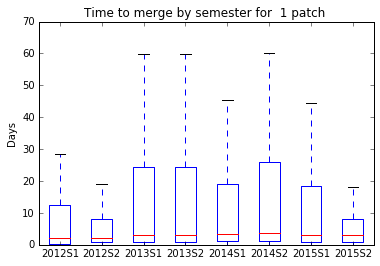

In [124]:
draw_boxplots(" 1 patch ", time2merge_extra_df_1patch, "first_patch_date")


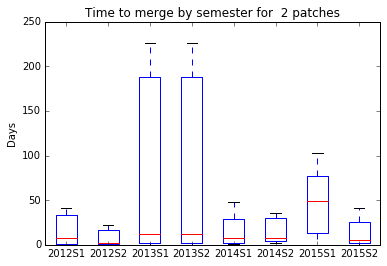

In [125]:
draw_boxplots(" 2 patches", time2merge_extra_df_2patch, "first_patch_date")



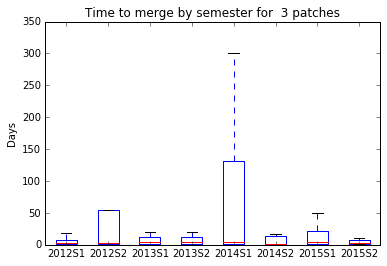

In [126]:
draw_boxplots(" 3 patches", time2merge_extra_df_3patch, "first_patch_date")


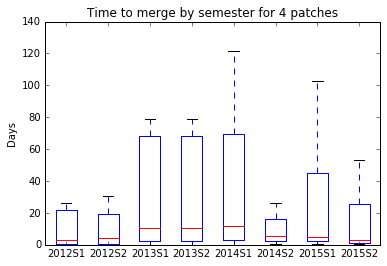

In [113]:
draw_boxplots(" 4 patches", time2merge_extra_df_4patch, "first_patch_date")


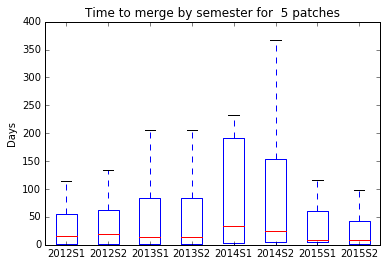

In [127]:
draw_boxplots(" 5 patches", time2merge_extra_df_5patch, "first_patch_date")

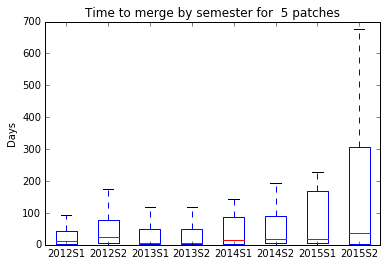

In [128]:
draw_boxplots(" 5 patches", time2merge_extra_df_5patch, "merge_time")

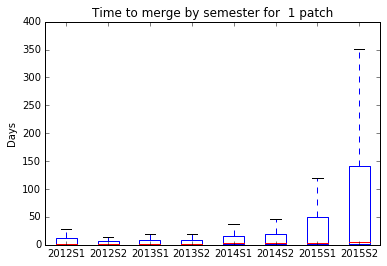

In [129]:
draw_boxplots(" 1 patch", time2merge_extra_df_1patch, "merge_time")

In [130]:
#time2merge_extra_df_1patch

## Evolution of the number of patches per patch serie (so, are longer patch series taking place lately?)

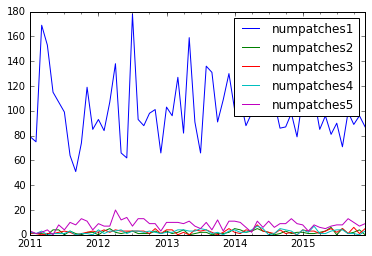

In [131]:
total_patch_series_1 = time2merge_extra_df_1patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_2 = time2merge_extra_df_2patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_3 = time2merge_extra_df_3patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_4 = time2merge_extra_df_4patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})
total_patch_series_5 = time2merge_extra_df_5patch.set_index("first_patch_date").resample('M', how={"numpatches":np.size})

#fig, ax = plt.subplots()
dates = pd.date_range('2011-01', '2016-01', freq='M') # data starting in 2005-10 and ending in 2015-08

total_patch_series_1["numpatches1"] = total_patch_series_1["numpatches"]
total_patch_series_2["numpatches2"] = total_patch_series_2["numpatches"]
total_patch_series_3["numpatches3"] = total_patch_series_3["numpatches"]
total_patch_series_4["numpatches4"] = total_patch_series_4["numpatches"]
total_patch_series_5["numpatches5"] = total_patch_series_5["numpatches"]

patches1TS = Series(total_patch_series_1["numpatches1"], index=dates)
patches2TS = Series(total_patch_series_2["numpatches2"], index=dates)
patches3TS = Series(total_patch_series_3["numpatches3"], index=dates)
patches4TS = Series(total_patch_series_4["numpatches4"], index=dates)
patches5TS = Series(total_patch_series_5["numpatches5"], index=dates)

patches_chart = patches1TS.plot()
patches2TS.plot()
patches3TS.plot()
patches4TS.plot()
patches5TS.plot()
patches_chart.legend()

## Relationship between the median time to merge and the existence of patch series bigger than 4 patches

In [132]:
patches5TS.corr(time2merge_medianTS)

-0.042508489612202806

## Coverage analysis

In [133]:
#unique patches
query = """select year(p.date),
                  count(distinct(p.id)) 
           from patches p,
				patch_series_version psv 
           where psv.version=1 and 
                 psv.id=p.ps_version_id 
           group by year(p.date) """
unique_patches = execute_query(cursor, query)
unique_patches

((2011L, 3510L),
 (2012L, 4031L),
 (2013L, 3660L),
 (2014L, 3224L),
 (2015L, 3123L),
 (2016L, 559L))

In [134]:
#Unique patches matched to commits
query = """ select year(date),
                   count(distinct(commit_id)) 
            from patches 
            group by year(date) """
matched_commits = execute_query(cursor, query)
matched_commits

((2011L, 2104L),
 (2012L, 2267L),
 (2013L, 2165L),
 (2014L, 2100L),
 (2015L, 2057L),
 (2016L, 208L))